In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
#import losses
#importlib.reload(losses)
#from losses import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
#from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


Using device: cuda


In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [3]:
batch_size=64
individual = False
_dataSB28, _labelsSB28, _minmaxSB28 = loadCAMELS(field="Mtot",box="SB28", normalization=False, individual=individual)
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
_data1P, _labels1P, _minmax1P = loadCAMELS(field="Mtot",box="1P", normalization=False, individual=individual)
_dataCV, _labelsCV, _minmax1P = loadCAMELS(field="Mtot",box="CV", normalization=False, individual=individual)
#_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
labels1P = torch.tensor(_labels1P, dtype=dtype)
labelsCV = torch.tensor(_labelsCV, dtype=dtype)

In [4]:
if individual:
  arr = np.arange(_dataSB35.shape[0])
  step = 10
  length = 5

  # compute all start‐indices
  starts = np.arange(0, len(arr)-length+1, step)   # [  0,  30,  60, …]
  # build a 2D index array of shape (n_chunks, length)
  idx = starts[:,None] + np.arange(length)   
  idx = idx.flatten()

  dataSB35_cutout2_norm = np.log10(_dataSB35[idx,:256,:256])
  dataSB35_cutout2_mean, dataSB35_cutout2_std =\
  dataSB35_cutout2_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout2_norm.std(axis=(1, 2), keepdims=True)
  dataSB35_cutout2_norm = (dataSB35_cutout2_norm -  dataSB35_cutout2_mean)/dataSB35_cutout2_std

  dataSB35_cutout2_norm = torch.tensor(dataSB35_cutout2_norm,dtype=dtype).to(device)
  #labelsSB35 = (_labelsSB35-_minmaxSB35[:2,0])/(_minmaxSB35[:2,1]-_minmaxSB35[:2,0])
  _, val_set = split_expanded_dataset(dataSB35_cutout2_norm, labelsSB35, chunk_size=15, val_ratio=0.2)
  val_loaderSB35_cutout2 = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
else:
  _dataSB35_cutout, _labelsSB35_cutout, _ = loadCAMELS(field="Mtot",box="SB35",normalization=True,
                                            linear=False, buffer=0.3, individual=individual)
  arr = np.arange(_dataSB35_cutout.shape[0])
  step = 10
  length = 5

  # compute all start‐indices
  starts = np.arange(0, len(arr)-length+1, step)   # [  0,  30,  60, …]
  # build a 2D index array of shape (n_chunks, length)
  idx = starts[:,None] + np.arange(length)   
  idx = idx.flatten()

  dataSB35_cutout = torch.tensor(_dataSB35_cutout[idx,:256,:256],dtype=dtype).to(device)
  _, val_set = split_expanded_dataset(dataSB35_cutout2, labelsSB35, chunk_size=15, val_ratio=0.2)
  val_loaderSB35_cutout   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

NameError: name 'dataSB35_cutout2' is not defined

In [11]:
linear = False
#dataSB28_norm = np.log10(_dataSB28[:,:224,:224])
dataSB28_norm = np.log10(_dataSB28)
if linear:
  dataSB28_norm_max, dataSB28_norm_min = dataSB28_norm.max(), dataSB28_norm.min()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB28_norm_mean, dataSB28_norm_std =\
      dataSB28_norm.mean(axis=(1, 2), keepdims=True), dataSB28_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB28_norm_mean, dataSB28_norm_std = dataSB28_norm.mean(), dataSB28_norm.std()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_mean)/dataSB28_norm_std


dataSB35_norm = np.log10(_dataSB35)
if linear:
  dataSB35_norm_max, dataSB35_norm_min = dataSB35_norm.max(), dataSB35_norm.min()
  dataSB35_norm = (dataSB35_norm -  dataSB35_norm_min)/(dataSB35_norm_max-dataSB35_norm_min)
else:
  if individual:
    dataSB35_norm_mean, dataSB35_norm_std =\
      dataSB35_norm.mean(axis=(1, 2), keepdims=True), dataSB35_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB35_norm_mean, dataSB35_norm_std = dataSB35_norm.mean(), dataSB35_norm.std()
  dataSB35_norm = (dataSB35_norm -  dataSB35_norm_mean)/dataSB35_norm_std

"""
#dataSB35_cutout = np.r_[_dataSB35[:,:256,:256],_dataSB35[:,:256,256:]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,:256]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,256:]]
#dataSB35_cutout_norm = np.log10(dataSB35_cutout)
dataSB35_cutout_norm = np.log10(_dataSB35_cutout[:,:256,:256])
if linear:
  dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB35_cutout_norm_mean, dataSB35_cutout_norm_std =\
      dataSB35_cutout_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout_norm.std(axis=(1, 2), keepdims=True)
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB35_cutout_norm_mean)/dataSB35_cutout_norm_std
  else:
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_mean)/dataSB28_norm_std
"""


data1P = np.log10(_data1P)
data1P_norm = (data1P -  dataSB28_norm_mean)/dataSB28_norm_std

dataCV = np.log10(_dataCV)
dataCV_norm = (dataCV -  dataSB28_norm_mean)/dataSB28_norm_std

  
data1P = np.log10(_data1P)
data1P_cutout_norm = (data1P -  dataSB35_norm_mean)/dataSB35_norm_std

dataCV = np.log10(_dataCV)
dataCV_cutout_norm = (dataCV -  dataSB35_norm_mean)/dataSB35_norm_std




dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
_, val_setSB28 = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2, shuffle=True)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

data1P = torch.tensor(data1P_norm,dtype=dtype)
data1P_cutout = torch.tensor(data1P_cutout_norm,dtype=dtype)
dataCV = torch.tensor(dataCV_norm,dtype=dtype)
dataCV_cutout = torch.tensor(dataCV_cutout_norm,dtype=dtype)



#dataSB35_cutout = torch.tensor(dataSB35_cutout_norm,dtype=dtype)
#_, val_setSB35_cutout = split_expanded_dataset(dataSB35_cutout, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
#val_loaderSB35_cutout = DataLoader(val_setSB35_cutout, batch_size=batch_size, shuffle=False)

#dataSB35 = torch.tensor(dataSB35_norm,dtype=dtype)
#_, val_setSB35 = split_expanded_dataset(dataSB35, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
#val_loaderSB35 = DataLoader(val_setSB35, batch_size=batch_size, shuffle=False)

In [32]:
data1P = torch.tensor(data1P_norm,dtype=dtype)
_, val_setCV = split_expanded_dataset(data1P, labels1P, chunk_size=15, val_ratio=1.0, shuffle=True)
val_loader1P = DataLoader(data1P, batch_size=batch_size, shuffle=False)

RuntimeError: torch.cat(): expected a non-empty list of Tensors

### Plot

In [4]:
def get_predictions(model, val_loader, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    #mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    #mse_total = mse_per_dim.mean()
    #print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    #mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    #mse_total = mse_per_dim.mean()
    #print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]


def get_predictions1(model, model1, inputs, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    #pred = []

    with torch.no_grad():
        predictions = []
        predictions1 = []
        inputs = torch.tensor(inputs)
        if inputs.shape[0] > batch_size:
            for i in range((inputs.shape[0]+batch_size-1)//batch_size):
                start = batch_size*i
                end   = min(batch_size*(i+1),inputs.shape[0])
                _inputs = inputs[start:end]
                _inputs = _inputs.view(_inputs.size(0),1,256,256)
                _inputs = _inputs.to(device)
                outputs = model(_inputs)
                outputs1 = model1(_inputs)
                predictions.append(outputs.cpu())
                predictions1.append(outputs1.cpu())
        else:
            _inputs = inputs.view(inputs.size(0),1,256,256)
            _inputs = _inputs.to(device)

            outputs = model(_inputs)
            outputs1 = model1(_inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())

        predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
        predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
        predictions = np.c_[predictions,predictions1]
        predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
        pred = predictions

    # Plot prediction vs truth for a few dimensions
    return pred

### trained separately

In [12]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]





model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model3 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model3.to(device)

model.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_om_best.pt"))
model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_best.pt"))
model2.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_best.pt"))
model3.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_best.pt"))

#data28        = get_predictions2(model, model1, val_loaderSB28, _minmaxSB28, device=device)
data1P = get_predictions1(model, model1, data1P_norm, _minmaxSB28, device=device)
data1P_cutout = get_predictions1(model2, model3, data1P_cutout_norm, _minmaxSB35, device=device)
dataCV = get_predictions1(model, model1, dataCV_norm, _minmaxSB28, device=device)
dataCV_cutout = get_predictions1(model2, model3, dataCV_cutout_norm, _minmaxSB35, device=device)
#data35_cutout2 = get_predictions2(model2, model3, val_loader1P, _minmaxSB35, device=device)
#data28_cutout2 = get_predictions2(model2, model3, val_loaderCV, _minmaxSB35, device=device)


In [38]:
data1P[0].shape

(2100, 2)

In [47]:
labels1P.shape

torch.Size([140, 28])

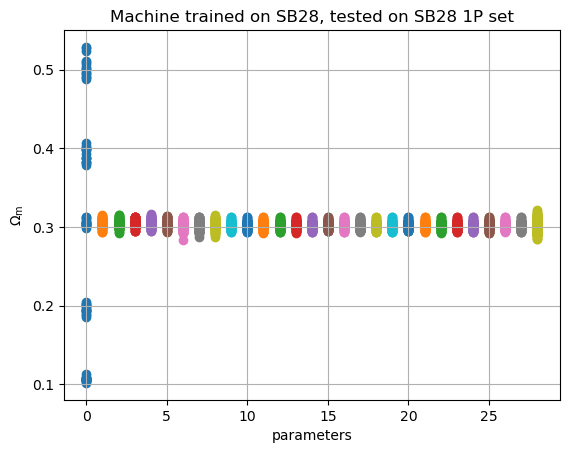

In [26]:
predictions = data1P
for i in range(28):
  #for j in range(5):
  start = i*5*15
  end = (i+1)*5*15
  plt.scatter([i]*5*15, predictions[start:end,0])#, c=labels1P[i*5:(i+1)*5,i])

predictions = dataCV
plt.scatter([28]*predictions.shape[0], predictions[:,0])
plt.grid()
plt.ylabel(r"$\Omega_\mathrm{m}$")
plt.xlabel("parameters")
plt.title("Machine trained on SB28, tested on SB28 1P set")
plt.savefig("SB28_1P_on_SB28.png", dpi=100, bbox_inches='tight')

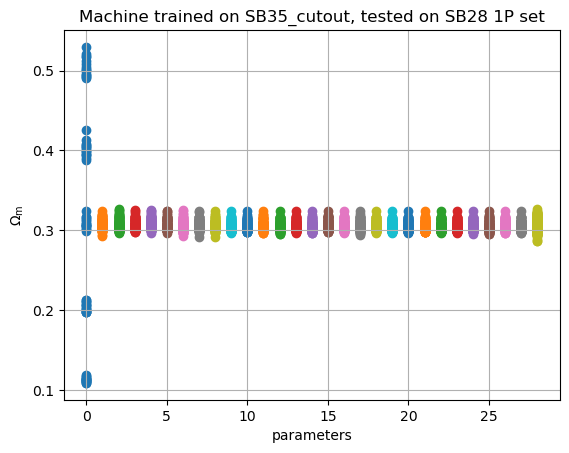

In [25]:
predictions = data1P_cutout
for i in range(28):
  #for j in range(5):
  start = i*5*15
  end = (i+1)*5*15
  plt.scatter([i]*5*15, predictions[start:end,0])#, c=labels1P[i*5:(i+1)*5,i])

predictions = dataCV_cutout
plt.scatter([28]*predictions.shape[0], predictions[:,0])
plt.grid()
plt.ylabel(r"$\Omega_\mathrm{m}$")
plt.xlabel("parameters")
plt.title("Machine trained on SB35_cutout, tested on SB28 1P set")
plt.savefig("SB28_1P_on_SB35_cutout.png", dpi=100, bbox_inches='tight')

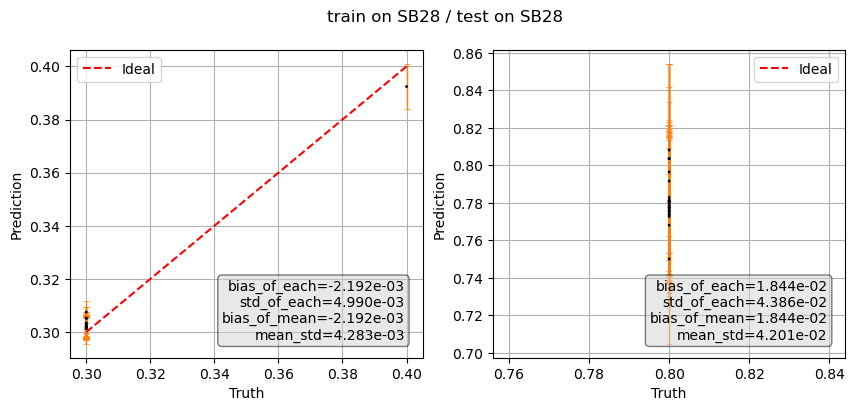

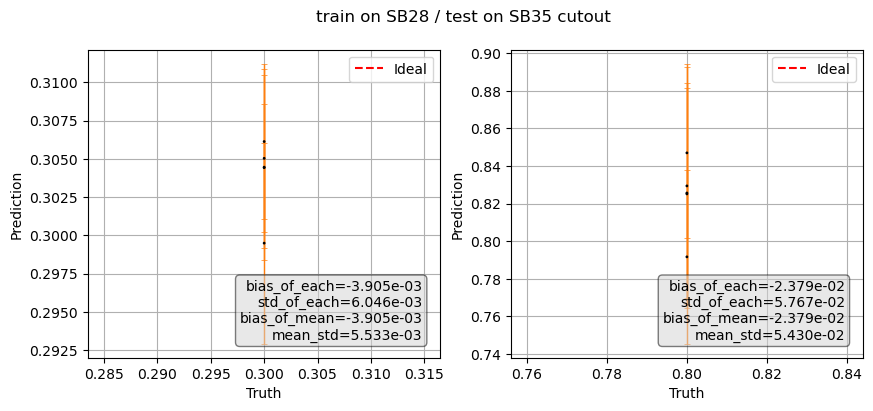

In [19]:
indices = None #range(10) #[0, 1, 2, 40]

if indices is None:
  plot_per_simulation(data1P, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28")
  plot_per_simulation(dataCV, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB35 cutout")
  #plot_per_simulation(data35_cutout2, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 cutout / test on SB35 cutout")
  #plot_per_simulation(data28_cutout2, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 cutout / test on SB28")
  #plot_per_simulation(data35, max_plots=6, chunk_size=30,num_samples=200, title="train on SB35 / test on SB35")
#plt.savefig("train_on_SB28_test_on_both.png")